# Bayesian Learning Assignment 2

MSc DSAI Quentin Le Roux

<hr>
<hr>
<hr>

## Library Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.optimize import minimize
from scipy.special import logsumexp
from scipy.stats import norm, uniform, binom
from scipy.stats import multivariate_normal
from sklearn import datasets 

<hr>

## Function declarations

**Note**: 
- *Functions are listed per exercise in alphabetical orders*
- *Functions are provided with Type Hinting*

### Exercise 1 functions

In [2]:
def beta_binomial_distribution(
    n: int, y: int, alpha: int, beta: int
) -> np.array:
    """
    Returns the beta-binomial distribution over the space of 
    parameter theta, given the parameters alpha, beta, y, and n.
    """
    # Declares a linear space for the parameter theta
    theta_space  = np.linspace(0,1)
    # Computes and return the distribution
    distribution = theta_space**(y+alpha-1) * \
                   (1-theta_space)**(n+beta-y-1)
    return theta_space, distribution

def beta_binomial_lapproximation(
    n: int, y: int, alpha: int, beta: int
) -> np.array:
    """
    Returns the Laplace approximation of the beta binomial
    distribution (a Gaussian distribution) with parameters
    derived from the original distribution's parameters alpha,
    beta, y, and n.
    """
    theta_max = (y+alpha-1)/(n+alpha+beta-2)
    hessian   = -(y+alpha-1)/(theta_max**2) - \
                (n+beta-y-1)/((1-theta_max)**2)
    variance  = -1/hessian
    return norm(theta_max, np.sqrt(variance))

### Exercise 4 functions

*Some functions will be reused in exercise 5*.

In [3]:
def evaluate_log_post(
    params: list, 
    other_params: list, 
    data: pd.Series, 
    likelihood: str, 
    priors: list
) -> float:
    """
    Optimization function to be used for performing a Laplace
    approximation.
    """
    # Retrieves the distribution function (scipy implementation)
    models = {
        "gaussian":norm, 
        "uniform":uniform,
        "binomial":binom,
        
    }
    #Computes the log-priors
    log_prior = 0 
    for i, mod in enumerate(priors):
        log_prior += models[mod[0]].logpdf(params[i], *mod[1]) 
    # Guarantees positive variance in the Gaussian case
    if likelihood == "gaussian": params[-1] = np.abs(params[-1])
    # Checks for the other set of parameters
    if len(other_params) > 0: params = (params, other_params)
    # Computes the log-likelihood
    log_likelihood = np.sum([models[likelihood].logpdf(point, *params) 
                             for point in data])
    return - (log_likelihood + log_prior)

def evaluate_log_post_regression(
    params: list, 
    var_names: list, 
    data: pd.Series, 
    likelihood: str, 
    priors: list
) -> float:
    """
    Optimization function to be used for performing a Laplace approximation
    as part of a linear regression process.
    """
    # Retrieves the distribution function (scipy implementation)
    models = {
        "gaussian":norm, 
        "uniform":uniform,
        "binomial":binom
    }
    #Computes the log-priors
    log_prior = 0 
    for i, mod in enumerate(priors):
        log_prior += models[mod[0]].logpdf(params[i], *mod[1]) 
    #Evaluating expression
    target, predictors = var_names[0], var_names[1]
    # Computes the Gaussian parameters
    mu = np.ones(len(data[predictors[0]])) * params[0]
    for i in range(len(predictors)):
        mu += params[i+1] * data[predictors[i]].values
    sigma = np.abs(params[-1])
    # Computes the log-likelihood
    t = data[target].values
    N = len(t)
    log_lik = np.sum([norm.logpdf(t[i], mu[i], sigma) for i in range(N)])
    return -(log_lik + log_prior)

def laplace_solution(
    params:list,
    other_params: list,
    data: pd.Series,
    likelihood: str,
    priors:list
) -> list:
    """
    Computes a Laplace approximation of a distribution given sets of
    prior and likelihood parameters.
    """    
    # Performs an optimization over a set of parameters given an
    # evaluation function.
    minimum =  minimize(
        evaluate_log_post, params,  
        args = (other_params, data, likelihood, priors) #, method = "BFGS"
    )
    print(minimum)
    return [minimum.x, minimum.hess_inv]

def laplace_solution_regression(
    expression: str, 
    data: pd.DataFrame, 
    likelihood: str, 
    priors: list
) -> list:
    """
    Computes a Laplace approximation for a regression given sets
    of priors and likelihood parameters
    """
    # Retrieves the distribution function (scipy implementation)
    models = {
        "gaussian": norm, 
        "uniform": uniform,
        "binomial": binom
    }
    # Parses the linear regression expression
    collapsed_expression = expression.replace(" ", "")
    target, independent = collapsed_expression.split("~") 
    independent = independent.split("+")
    var_names = [target, independent]
    # Computes the random variates for each prior
    params = [models[priors[i][0]].rvs(*priors[i][1]) 
              for i in range(len(priors))]
    # Performs an optimization over a set of parameters given an
    # evaluation function.
    minimum =  minimize(
        evaluate_log_post_regression, params, 
        args = (var_names, data, likelihood, priors) #, method = "BFGS"
    )
    print(minimum, "\n")
    return [minimum.x, minimum.hess_inv]

def plot_relationship(
    x: pd.Series, y: pd.Series,
    xlabel: str, ylabel:str,
    title: str
) -> None:
    """
    Plots the 2D plot of the relationship between two variables.
    """
    plt.figure()
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show

def plot_variation(
    data: pd.DataFrame,
    depvar_name: str,
    covar_mean: list,
    covar_name: str,
    plot_title: str,
    plot_xlabel: str,
    plot_ylabel: str,
    posterior_samples: np.ndarray,
    posterior_means: np.ndarray,
    higher_order: bool = False,
    max_order: int = 1
):
    """
    Plots the predictive regression of a dataset.
    """
    # Computes the range of the plot area
    x_range = np.linspace(min(data[covar_name]), max(data[covar_name]))
    mean_prediction = posterior_means[0] + \
                      np.sum([posterior_means[i] * x_range**(i if higher_order else 1) 
                              for i in range(1, max_order+1)],
                             axis=0)
    # Samples from a posterior distribution to obtain a predictive interval for
    prediction_range = [
        posterior_samples[:,0] + \
        np.sum([posterior_samples[:,i] * _x**(i if higher_order else 1)
        for i in range(1, max_order+1)], axis=0)
        for _x in x_range
    ]
    prediction_range_noise = [
        norm.rvs(prediction, posterior_samples[:,-1]) 
        for prediction in prediction_range
    ]
    # Plots the base of the counterfactual graph
    n = posterior_samples.shape[0]
    plt.plot(x_range + covar_mean, mean_prediction, lw=2, color="black")
    plt.scatter(data[covar_name] + covar_mean, data[depvar_name])
    plt.title(plot_title)
    plt.xlabel(plot_xlabel)
    plt.ylabel(plot_ylabel)
    # Plotting the uncertainty
    for i, _x in enumerate(x_range): 
        plt.scatter(np.repeat(_x,n) + covar_mean, prediction_range_noise[i], alpha = 0.05, color = 'grey')
    for i, _x in enumerate(x_range): 
        plt.scatter(np.repeat(_x,n) + covar_mean, prediction_range[i], alpha = 0.05, color = 'green')
    
def posterior_sampling_laplace(
    solution: list, 
    n_samples: int
) -> list:
    """
    Computes a sampling of a posterior distribution
    yielded from a Laplace approximation.
    """
    posterior_samples = multivariate_normal.rvs(
        solution[0], solution[1], size = n_samples
    )
    return posterior_samples
    
def sampling_from_posterior(
    data: pd.DataFrame, 
    mean_covariate: float, 
    depvar_name: str, 
    covar_name: str, 
    posterior_samples: multivariate_normal.rvs,
    posterior_means: list,
    plot_title: str,
    plot_xlabel: str,
    plot_ylabel: str
) -> None:
    """
    Samples datapoints from a posterior distribution and plots the resulting
    distribution.
    """
    # Samples from the posterior
    x_range = np.linspace(min(data[covar_name]), max(data[covar_name]))
    mean_prediction = posterior_means[0] + posterior_means[1] * x_range
    for i in range(1000):
        prediction = posterior_samples[i,0] + posterior_samples[i,1] * x_range
        plt.plot(x_range + mean_covariate, prediction, lw = 0.05, color = 'grey')
    # Plots the resulting plot
    plt.scatter(data[covar_name] + mean_covariate, data[depvar_name])
    plt.plot(x_range + mean_covariate, mean_prediction, lw = 2, color = 'black')
    plt.title(plot_title)
    plt.ylabel(plot_ylabel)
    plt.xlabel(plot_xlabel)
    plt.show()

def summarize(
    solution: list, 
    names: dict={0:'a',1:'b', 2:'sigma'}, 
    plot: bool=False
) -> tuple:
    """
    Summarizes the regression statistics obtained via a
    Laplace approximation.
    """
    # Computes posterior samples
    posterior_samples = posterior_sampling_laplace(
        solution, 5000
    )
    #### Computes summary stats
    #    85% confidence interval
    post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
    #    standard deviation
    post_sd = np.std(posterior_samples, axis = 0)
    #     mean
    post_mean = np.mean(posterior_samples, axis = 0)
    # Prints the results
    summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
    summary_stats.rename(index=names, inplace=True)
    print(summary_stats, "\n")
    # If requested, prints the plot of the posterior data
    if plot:
        boxes = []
        for i in range(len(post_mean)):
            boxes.append(posterior_samples[:,i])
        plt.boxplot(boxes,vert=0)
        plt.yticks(range(len(post_mean)+1)[1:], names)
        plt.axvline(x=0, color = 'black', alpha = 0.1)
        plt.show()
    # Returns the posterior samples
    return post_mean, post_sd, posterior_samples

### Exercise 5 functions

*Exercise 5 reuses functions from exercise 4*.

In [4]:
def compute_WAIC(
    depvar_name: str,
    covar_name: str,
    max_order: int, 
    n_sampling: int,
    posterior_samples: list, 
    data: pd.DataFrame
) -> tuple:
    """
    Computes the WAIC metric for a set of regression model, given
    an order (linear, quadratic, cubic or fourth-order), posterior 
    sampling parameters and a dataset.
    """
    # Declares the pointwise predictive distribution and widely 
    # applicable information criterion objects to record
    lppd = []
    p_waic = []
    # Computes the log-probability for each datapoint of the 
    # dependent variable
    for i, target in enumerate(data[depvar_name]):
        # declares a lambda function computing the mean of the 
        # log pdf
        prediction = lambda s, order: posterior_samples[s, 0] + \
                     np.sum([posterior_samples[s,o] * data[f"{covar_name}{o}"][i]
                             for o in range(1, order+1)], axis = 0)
        # Computes the log-proba of the datapoint given a sampling size
        log_p = [norm.logpdf(target, loc=prediction(s, max_order), 
                             scale=posterior_samples[s, -1]) 
                 for s in range(n_sampling)]
        # Appends the results
        lppd.append(logsumexp(log_p) - np.log(len(log_p)))
        p_waic.append(np.var(log_p))
    return lppd, p_waic

def plot_boxplot_regression(
    solution: list,
    depvar_name: str,
    plot_title: str
):
    """
    Plots the confidence interval of the b (slope) parameter
    within an univariate regression between two variables. It
    allows to see if the confidence interval overlaps or falls
    away from zero.
    """
    # Samples the posterior distribution of the slope b as part
    # of an univarite regression
    boxes = posterior_sampling_laplace(solution, 5000)[:,1]
    # Plots the boxplot
    plt.figure()
    plt.boxplot(boxes,vert=0)
    plt.yticks([1], [depvar_name])
    plt.axvline(x=0, color = "black", alpha = 0.1)
    plt.title(plot_title)
    plt.show()

def plot_posterior_univariate_regression(
    solution: list, 
    x_range: np.ndarray, 
    data: pd.DataFrame, 
    center: int = 0, 
    names: list = ['x','y'], 
    n_samples: int = 5000
):
    """
    Plots the univariate regression plot of a sampling of a
    posterior distribution computed with a Laplace approximation.
    """
    # Samples from the posterior distribution obtained via
    # Laplace approximation to obtains data statistics
    post_samples = posterior_sampling_laplace(solution, n_samples)
    degree = post_samples.shape[1] - 1
    post_mean = np.mean(post_samples, axis = 0)
    mean_prediction = np.zeros(len(x_range)) + \
                      sum([post_mean[i] * x_range**i for i in range(degree)])
    # Plots the results of the sampling
    plt.plot(x_range + center, mean_prediction, lw = 2, color = 'black')
    plt.title('regression result')
    plt.ylabel(names[1])
    plt.xlabel(names[0])
    list_model_samples = []
    # Samples from the posterior to get a predictive interval
    for n in range(n_samples):
        mod_sample = np.zeros(len(x_range))
        for i in range(degree):
            mod_sample += post_samples[n,i] * x_range**i
        list_model_samples.append(mod_sample)
    prediction_noise = []
    for i,mod_sample in enumerate(list_model_samples):
        prediction_noise.append(norm.rvs( mod_sample, post_samples[i,-1]))  
    # Plots the uncertainty
    for i in range(n_samples): 
        plt.scatter(x_range + center, prediction_noise[i], alpha = 0.05, color = 'grey')
        plt.scatter(x_range + center, list_model_samples[i], alpha = 0.05, color = 'green')
    plt.scatter( data[names[0]] + center, data[names[1]])
    
def summarize_WAIC_statistics(
    depvar_name: str,
    covar_name: str,
    max_order: int, 
    n_sampling: int,
    posterior_samples: list, 
    data: pd.DataFrame
) -> None:
    """
    Computes the summary of the statistic yielded with the WAIC
    method: WAIC, pWAIC, dWAIC, weight, SE, d_SE
    """
    # Declares empty variable lists for the WAIC and SE
    waic_models = []
    waic_vect_models = []
    p_waic_models = []
    se_models = []
    # For each model (with a given order), computes the WAIC and SE
    # and stores them
    for i in range(1, max_order+1):
        lppd, p_waic = compute_WAIC(depvar_name, covar_name, 
                                    i, n_sampling, 
                                    posterior_samples[i-1], data)
        waic_vect = -2*(np.array(lppd) - np.array(p_waic))
        waic = sum(waic_vect)
        p_waic = sum(p_waic)
        se = np.sqrt(len(data[depvar_name]) * np.var(waic_vect))
        # Records the results
        waic_models.append(waic)
        waic_vect_models.append(waic_vect)
        p_waic_models.append(p_waic)
        se_models.append(se)
    waic_models = np.array(waic_models)
    # Declares empty variables lists for the rest of the statistics
    d_waic = np.zeros(waic_models.shape)
    weights = np.zeros(waic_models.shape)
    d_se = np.zeros(waic_models.shape)
    # Computes the statistics
    for i in range(len(waic_models)):
        d_waic[i] = np.abs(waic_models[i] - min(waic_models))
    min_index = np.argmin(d_waic)
    for i in range(len(waic_models)):
        weights[i] = np.exp(-0.5*d_waic[i]) / (np.sum(np.exp(-0.5*d_waic)))
        if i != min_index:
            d_se[i] = np.sqrt(len(data[depvar_name])* \
                              np.var(waic_vect_models[i] - waic_vect_models[min_index]))
        else:
            d_se[i] = np.nan
    # Prints the summary
    summary_stats = [waic_models, p_waic_models, d_waic, weights, se_models, d_se]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ["WAIC", "pWAIC", "dWAIC", "weight", "SE", "d_SE"]
    summary_stats.index = [f"model{o}" for o in range(1, max_order+1)]
    print(summary_stats)

### Exercise 6 functions

In [5]:
def summarize_WAIC_statistics_different_models(
    depvar_name: str,
    n_sampling: int,
    data: pd.DataFrame,
    expressions: dict,
    solutions: list
):
    # Declares empty variable lists for the WAIC and SE
    waic_models = []
    waic_vect_models = []
    p_waic_models = []
    se_models = []
    for i, model in enumerate(expressions):
        lppd = []
        p_waic = []
        # Initializing the likelihood
        likelihood = 'gaussian'
        posterior_samples = posterior_sampling_laplace(solutions[i], n_sampling)

        for t, target in enumerate(data[depvar_name]):
            log_p = []
            for l in range(n_sampling):
                pred = posterior_samples[l,0] 
                for i, elem in enumerate(list(expressions[model][1].values())[1:-1]):
                    pred += posterior_samples[l,i]*data[elem][t]
                log_p.append(norm.logpdf(target, loc=pred, scale=posterior_samples[l,-1]))
            lppd.append(logsumexp(log_p) - np.log(len(log_p)))
            p_waic.append(np.var(log_p))
        waic_vect = -2*(np.array(lppd) - np.array(p_waic))
        waic = -2*(np.sum(lppd) - np.sum(p_waic))
        p_waic = np.sum(p_waic)
        se = np.sqrt(len(data[depvar_name])*np.var(waic_vect))
        # Records the results
        waic_models.append(waic)
        waic_vect_models.append(waic_vect)
        p_waic_models.append(p_waic)
        se_models.append(se)
    waic_models = np.array(waic_models)
    # Declares empty variables lists for the rest of the statistics
    d_waic = np.zeros(waic_models.shape)
    weights = np.zeros(waic_models.shape)
    d_se = np.zeros(waic_models.shape)
    # Computes the statistics
    for i in range(len(waic_models)):
        d_waic[i] = np.abs(waic_models[i] - min(waic_models))
    min_index = np.argmin(d_waic)
    for i in range(len(waic_models)):
        weights[i] = np.exp(-0.5*d_waic[i]) / (np.sum(np.exp(-0.5*d_waic)))
        if i != min_index:
            d_se[i] = np.sqrt(len(data[depvar_name])* \
                              np.var(waic_vect_models[i] - waic_vect_models[min_index]))
        else:
            d_se[i] = np.nan
    # Prints the summary
    summary_stats = [waic_models, p_waic_models, d_waic, weights, se_models, d_se]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ["WAIC", "pWAIC", "dWAIC", "weight", "SE", "d_SE"]
    summary_stats.index = list(expressions.keys())
    print(summary_stats)

<hr>
<hr>
<hr>

## Exercise 1

### Instructions

The Beta-Binomial model seen during lesson 2 is:

$$p(y|\theta)p(\theta) \propto \theta^{y+\alpha-1}(1-\theta)^{n+\beta-y-1} \propto Beta(\theta|\alpha+y,n+\beta-y).$$

Find a Laplace approximation for this model, as seen for the Binomal model, and plot the resulting Gaussian approximation against the Beta-Binomial function.

<hr>

#### 1. Finding the Laplace approximation of the Beta-Binomial model

We recall that the Laplace method allows to approximate the shape of a given function with a Gaussian distribution. This approximation relies on the Taylor expansion of the (log-)function of interest *f*. Given *f* the function to approximate, we state the function *g* such that:

$$f(x) = \exp(\log(f(\theta)) = \exp(g(\theta))$$

Stopping at the second order, and assuming that *g* and *f* share a maximum in $\theta_0$, we can approximate *g* and thus *f* for any point $theta$ sufficiently close to $\theta_0$ such that:

\begin{align}
g(\theta) &= g(\theta_0) + g'(\theta_0)(\theta-\theta_0) + \frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2 + o((\theta - \theta_0)^3)\\
g'(\theta_0) &= 0 \\
\end{align}

We find the following approximation:

\begin{align}
g(\theta) &\approx g(\theta_0) + \frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2\\
f(\theta_0) &\approx f(\theta_0) + \exp(\frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2) \\
&\approx \exp\big(\frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2\big)\quad\text{Given $f(\theta_0)$ a constant}\\
&\approx \exp\big(-\frac{1}{2}\frac{(\theta-\theta_0)^2}{-\frac{1}{g''(\theta_0)}}\big)\quad\text{We recognize a Gaussian PDF}\\
\end{align}

As such, *f* can be approximated (up to a normalization constant) by a Gaussian distribution $\mathcal{N}(\theta_0, -\frac{1}{g''(\theta_0)})$

<u>Computing the maximum of the log-distribution:</u>

\begin{align}
g(\theta) & = \log(f(\theta)) = (y+\alpha-1)*\log(\theta) + (n+\beta-y-1)*\log(1-\theta)\\
\frac{\delta g}{\delta \theta} &= \frac{y+\alpha-1}{\theta} - \frac{n+\beta-y-1}{1-\theta}
\end{align}

As such:

\begin{align}
g'(\theta_0) &= 0\\
&\Rightarrow \frac{y+\alpha-1}{\theta_0} - \frac{n+\beta-y-1}{1-\theta_0} = 0\\
&\Rightarrow \frac{(1-\theta_0)*(y+\alpha-1) - \theta_0*(n+\beta-y-1)}{\theta_0(1-\theta_0)} = 0\\
&\Rightarrow (1-\theta_0)*(y+\alpha-1) - \theta_0*(n+\beta-y-1) = 0 \\
&\Rightarrow (2-n-\alpha-\beta)*\theta_0 +y+\alpha-1 = 0
\end{align}

We find:

$$\theta_0 = \frac{y+\alpha-1}{n + \alpha + \beta - 2}$$

<u>Computing the second derivative of the log-distribution with respect to $\theta$:</u>

\begin{align}
\frac{\delta^2 g}{\delta \theta^2} &= -\frac{y+\alpha-1}{\theta^2} - \frac{n+\beta-y-1}{(1-\theta)^2}
\end{align}

We find:

$$g''(\theta_0) = -\frac{y+\alpha-1}{(\frac{y+\alpha-1}{n + \alpha + \beta - 2})^2} - \frac{n+\beta-y-1}{(1-(\frac{y+\alpha-1}{n + \alpha + \beta - 2}))^2}$$

<u>Concluding on finding the Laplace approximation of the Beta-Binomial model:</u>

The approximation will be the Gaussian:

$$\mathcal{N}\big(\frac{y+\alpha-1}{n + \alpha + \beta - 2}, -(-\frac{y+\alpha-1}{(\frac{y+\alpha-1}{n + \alpha + \beta - 2})^2} - \frac{n+\beta-y-1}{(1-(\frac{y+\alpha-1}{n + \alpha + \beta - 2}))^2})^{-1}\big)$$

with mean $\theta_0 = \frac{y+\alpha-1}{n + \alpha + \beta - 2}$ and variance $\sigma^2=(\frac{y+\alpha-1}{(\frac{y+\alpha-1}{n + \alpha + \beta - 2})^2} + \frac{n+\beta-y-1}{(1-(\frac{y+\alpha-1}{n + \alpha + \beta - 2}))^2})^{-1}$

#### 2. Plotting the approximation

For plotting the resulting approximation, we will reuse the values for $\alpha$, $\beta$, $n$, and $y$ from class 5.

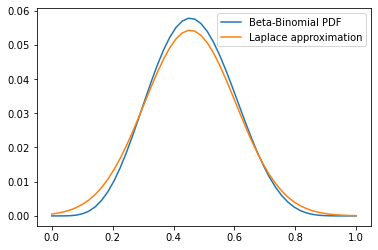

In [6]:
# Declares variables

y = 4; n = 8; alpha = 2; beta = 3

# Computes the beta-binomial PDF
theta_space, beta_binomial = beta_binomial_distribution(n, y, alpha, beta)

# Computes the beta-binomial approximation
lapproximation = beta_binomial_lapproximation(n, y, alpha, beta)

# Plots the results

plt.figure()
plt.plot(
    theta_space, beta_binomial/np.sum(beta_binomial), 
    label="Beta-Binomial PDF")
plt.plot(
    theta_space,
    lapproximation.pdf(theta_space)/np.sum(lapproximation.pdf(theta_space)),
    label="Laplace approximation")
plt.legend()
plt.show()

<hr>
<hr>
<hr>

## Exercise 2

### Instructions

Write down a model to evaluate the claim: *Animal diversity is related to latitude, but only after controlling for plant diversity*. You just need to write down the model definition.

<hr>

#### 1. Problem statement

From [wikipedia](https://en.wikipedia.org/wiki/Latitude), "*latitude is a geographic coordinate that specifies the north–south position of a point on the Earth's surface. Latitude is an angle (defined below) which ranges from 0° at the Equator to 90° (North or South) at the poles*." 

Common sense can lead us to assume that animal diversity is closely related to location (here, latitude). Furthermore, given prior knowledge, we may suppose that the most inhospitable areas in the world are located towards the poles, while the most hospitable would be closer to the equator (e.g. Amazonian Forest, Subsaharan Africa, etc.). Furthermore, since a biome is constituted by both fauna and flora, we can suppose that animal and plant diversity are tightly related.

As a caveat, this modeling is not without blind spots as areas such that the Sahara desert might influence the average diversity of a locale/latitude, as we are not interested in longitude as a parameter.

Finally, given these assumptions, we may hypothesize that:

- Any metric related to latitude would display some symmetric behavior with regards to the distance from the equator.
- The closer to the poles, i.e. the farther from the equator, the lower biome diversity:
    - Animal diversity and plant diversity are related
    - Diversity decreases with incrasing latitude

**Note:** Assuming any metric of animal diversity cannot be negative (at worse it would be zero), we could imagine a diversity metric as following a Poisson distribution at a given latitude.

<u>Possible example of a diversity metric per latitude given our assumptions:</u>

Represented on a graph with the x-axis the distance from the equator, and on the y-axis a metric evaluating animal diversity, we would expect a possibly linear, decreasing dataset of a form.

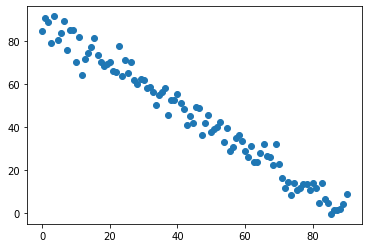

In [7]:
x = np.linspace(0, 90, num=100)
y = sorted(np.linspace(0, 90, num=100), reverse=True) + \
    np.random.normal(0, 5, 100)
plt.scatter(x, y); plt.show()

#### 2. Model definition

As such, since we are interested in a possible relationship between latitude and animal diversity, but we also want to account/control for plant diversity, we could defined a preliminary model as a linear regression with `animal diversity` as the dependent variable and `latitude` and `plant diversity` as the covariates. 

We are interested in the regression function $r$ such that:

$$r \rightarrow \mathbb{E}[animal\,diversity\,\,|\,\,latitude,\,\, plant\,diversity]$$

Our resulting linear model would be as such:

\begin{align}
\text{animal diversity} &= a+b*\text{latitude} + c*\text{plant diversity}\\\\
\text{with,}\\
a&,\text{ the intercept}\\
b, c&,\text{ respective covariates of latitude and plant diversity}
\end{align}

<hr>
<hr>
<hr>

## Exercise 3

### Instructions

Invent your own example of spurious correlation. An outcome variable should be correlated with both predictor variables. But when both predictors are entered in the same model, the correlation between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

<hr>

#### 1. Example of spurious correlation

From [Investopedia](https://www.investopedia.com/terms/s/spurious_correlation.asp), "*a spurious correlation (or spuriousness) refers to a connection between two variables that appears to be causal but is not. With spurious correlation, any observed dependencies between variables are merely due to chance or are both related to some unseen confounder.*"

An example could be the following:

> The sale of foie-gras is spuriously correlated to the sale of umbrellas in the Alpes-Maritimes, France.

If at face value it is obvious that the two variables are not causally linked, they are correlated through the underlying variable of seasonality -- the [rainiest months in the Alpes-Maritimes are October, November and December](https://en.wikipedia.org/wiki/Nice#Climate). Furthermore, foie-gras sales are [closely tied to the Christmas and New Year holidays](https://www.businesscoot.com/fr/etude/le-marche-du-foie-gras-france).

As such, we have a situation where the sale of foie-gras, being our dependent variable, should be correlated to both predictor variables: season/month of the year, and sales of umbrellas. Given a model where both covariates are included, we would expect the predictive aspect of the sales of umbrellas to decrease or disappear (since it also rains year round, albeit in a lower amount).

<hr>
<hr>
<hr>

## Exercise 4

### Instructions

The attached data is about observations of urban foxes in human habitat. The data has 5 columns:

- *group*: Number of social group the fox belongs to
- *avgfood*: The avg amount of food available in the territory
- *groupsize*: The number of foxes in the social group
- *area*: Size of the territory
- *weight*: Body weight of the fox

Fit a regression for *weight* as a linear function of *area*, and a regression for *weight* as a linear function of *groupsize*. What can you say about these relationships? Run a multivariate model and plot counterfactual plots for both variables. What can you conclude about this analysis?

<hr>

#### 1. Data import and exploration

In [8]:
data = pd.read_csv("data.csv")
data.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


[Text(0.5, 1.0, "Distribution of urban foxes' weight")]

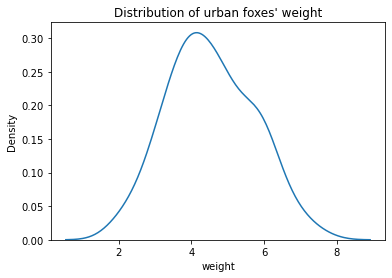

In [9]:
sns.kdeplot(data["weight"]).set(title="Distribution of urban foxes' weight")

[Text(0.5, 1.0, "Distribution of urban foxes' area")]

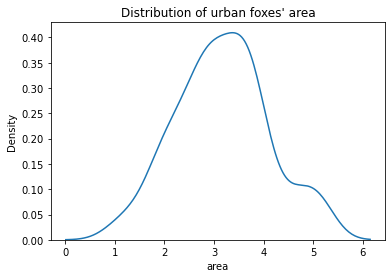

In [10]:
sns.kdeplot(data["area"]).set(title="Distribution of urban foxes' area")

[Text(0.5, 1.0, "Distribution of urban foxes' groupsize")]

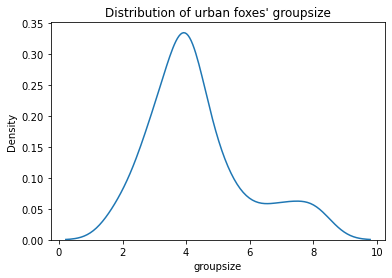

In [11]:
sns.kdeplot(data["groupsize"]).set(title="Distribution of urban foxes' groupsize")

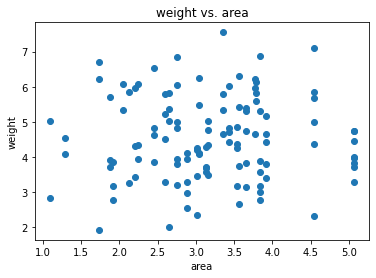

In [12]:
x, y, title= ("area", "weight", "weight vs. area")
plot_relationship(data[x], data[y], x, y, title)

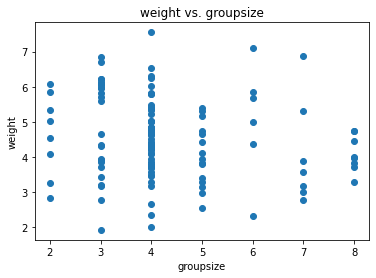

In [13]:
x, y, title= ("groupsize", "weight", "weight vs. groupsize")
plot_relationship(data[x], data[y], x, y, title)

<u>Observations:</u>

At first glance, the distribution of the dependent variable `weight` is somewhat Gaussian. That cannot be said of the possible covariates `area` and `groupsize`. Furthermore, plotting of `weight` against either covariates yields graphs that seem to indicate a somewhat weak relationship between each other. This will have to be verified.

#### 3. Estimating a model of `weight` sampling from prior mean and variance

<u>Selecting priors:</u>

We start by fitting a model for the variable `weight` only. Given the observed sample distribution, we can weakly assume that `weight` is Gaussian-distributed. `weight` is the result of infinitesimal accumulations of mass/growth during the life span (such as with the variable `height` seen in class).

Therefore, for each fox $i$, we may assume that their `weight` is distributed as: $\quad\text{weight}_i\sim N(\mu,\sigma^2)$.

As we can consider foxes as being fungible individuals, we can also suppose independence between each observation such that:

$$p(\text{weight}) = p(\text{weight}_1, \text{weight}_2, \ldots, \text{weight}_N) = p(\text{weight}_1).p(\text{weight}_2)\cdots p(\text{weight}_N)$$

This corresponds to a product of Gaussian likelihoods. Once set on using a Gaussian likelihood, we look into specifing a prior. We can use a Gaussian model encoding our belief by assuming:

\begin{align}
\mu_{prior} &\sim\,\,\mathcal{N}(4.5,3)\\
\sigma_{prior} &\sim\,\,\mathcal{U}(0,2)
\end{align}

**Interpretation**: The average weight of an urban fox is 4.5 kilograms with a $2\sigma$-variability of $[0.9kg, 8.1kg]$, which seem reasonable as we are including the whole fox population, from pups to the largest individuals. For the variance, we don't have a clear opinion on the matter and we can simply say that it is uniformly distributed on the interval $[0kg, 2kg]$.

<u>Integrating data in the model and obtaining its posterior:</u>

We specify our likelihood:

\begin{align}
p(y|\mu,\sigma^2) &= N(y|\mu,\sigma^2)\\\\
\text{with}&\,\\
y&,\,\,\text{the weight data}
\end{align}

<u>Using Laplace approximation:</u>

Because a grid method is computationally inefficient, and because we need to perform inference on $\sigma$ as well (which makes us reject using the closed form of the Gaussian), we use the Laplace approximation in order to yield a model of `weight`. As such, we rely on Laplace approximation.

In [14]:
# Declares the likelihood with the sample parameters
likelihood = "gaussian"; mu=4.53; sigma=1.18 #4.53, 1.18
parameters = [mu, sigma]

# Defines the prior mean
prior_mu_mean = 4.5; prior_mu_sigma = 3
prior_mu = ["gaussian", [prior_mu_mean, prior_mu_sigma]]

# Defines the prior sigma
sigma_inf = 0.; sigma_sup = 2.
prior_sigma = ["uniform", [sigma_inf, sigma_sup]]

# Performs the optimization
solution = laplace_solution(parameters, [], data["weight"], likelihood, [prior_mu, prior_sigma])

      fun: 186.399890424752
 hess_inv: array([[1.19675967e-02, 4.41943897e-06],
       [4.41943897e-06, 5.99152106e-03]])
      jac: array([-5.7220459e-06,  0.0000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([4.5296157 , 1.17890797])


The variable `solution` contains both the distribution parameters of the mean and variance of the posterior distribution of `weight`. As such, we explore this new model of `weight`:

In [15]:
posterior_samples = posterior_sampling_laplace(solution, 5000)
print(f"The mean of the `weight` parameters are: {posterior_samples.mean(axis=0)}.")
print(f"The standard deviation of the `weight` parameters are: {posterior_samples.std(axis=0)}.")
print(f"\nThe 85% quantile bounds for the `weight` parameters are:\n",
      np.quantile(posterior_samples, q=[0.075, 0.925], axis=0))

The mean of the `weight` parameters are: [4.52934754 1.17921409].
The standard deviation of the `weight` parameters are: [0.10841368 0.0786127 ].

The 85% quantile bounds for the `weight` parameters are:
 [[4.37167271 1.06831418]
 [4.68332541 1.29313946]]


<u>Note:</u>

Given this model, we will use the mean and standard deviation of $\mu$ as prior parameters for performing a regression of `weight` with its covariates.

#### 3. Performing a regression with `weight` as a linear function of `area`

Now that we explored in detail the urban foxes' `weight`, we can study the relationship bwetween `weight` and `area`. As such, we are interested in the relationship: 

$$\text{weight} = a + b * \text{area}$$

The intercept $a$ expresses the `weight` of an urban fox when its `area` territory area is null (which could represent transient foxes, pups, etc.) while the slope $b$ indicates how much the mass of a fox changes with the size of its territory.

From now on, we will assume that our previous Gaussian model of `weight` (seen above) is dependent on the variable `area` through this linear relationship. The rationale would be that a larger territory would grant a fox a larger hunting area and food. In this case, we assume that the `weight` of an urban fox would be sampled from a Gaussian distribution:

$$\text{weight}_i\sim \mathcal{N}(\mu_i,\sigma^2)$$

Along with this distribution, we state that:

$$\mu_i = a + b * \text{area}_i$$

i.e., the mean $\mu_i$ varies depending on area size, and the coefficient $a$ and $b$ as well as the noise $\sigma$ are assumed to be the same across subjects.

To define our Bayesian model, we specify priors for all the parameters we want to analyze:

\begin{align}
p(a) &= \mathcal{N}(4.5, 0.11)\tag{Based on our previous modeling of `weight`}\\
p(b) &= \mathcal{N}(1, 1)\\
p(\sigma) &= \mathcal{U}(0, 2)
\end{align}

Given we have no specific belief on the impact of `area` beyond that it should be somewhat positive on a fox's `weight` (even though the graph previously plotted doesn't seem to indicate that it is a strong relation), we specific the prior of b as a Gaussian distribution with mean 1 and standard deviation 1, and the variance as being uniform.

<u>Centering the data:</u>

We center the `area` variable to avoid scale effects.

In [16]:
# Centers the data
mean_area = data["area"].mean()
centered_data = data.copy()
centered_data["area"] -= mean_area

<u>Performing the Laplace regression:</u>

In [17]:
# Declares the regression expression
expression = "weight ~ area"

# Declares the likelihood
likelihood = "gaussian"

# Defines the prior with hyperparameters 
prior_a_mean = 4.5; prior_a_sigma = 0.11
prior_a = ["gaussian", [prior_a_mean, prior_a_sigma]]

prior_b_mean = 1.; prior_b_sigma = 1.
prior_b = ["gaussian", [prior_b_mean, prior_b_sigma]]

sigma_inf = 0.; sigma_sup = 2.
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ["uniform", prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Performs the optimization
solution = laplace_solution_regression(expression, centered_data, likelihood, priors)

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 184.4780411595852
 hess_inv: array([[ 6.14257532e-03,  1.69813110e-04, -3.47698351e-05],
       [ 1.69813110e-04,  1.40065540e-02,  1.68546819e-04],
       [-3.47698351e-05,  1.68546819e-04,  5.99692949e-03]])
      jac: array([ 0.00000000e+00,  1.90734863e-06, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 71
      nit: 13
     njev: 17
   status: 0
  success: True
        x: array([4.51490151, 0.03832518, 1.17884253]) 



<u>Summarizing the computed statistics:</u>

In [18]:
# Computes posterior samples
posterior_means, _, posterior_samples = summarize(solution)

           mean        SD      7.5%     92.5%
a      4.514851  0.078249  4.400408  4.625485
b      0.036051  0.118758 -0.131874  0.207540
sigma  1.177397  0.077436  1.064780  1.289639 



<u>Plotting the results with sampling from the posterior:</u>

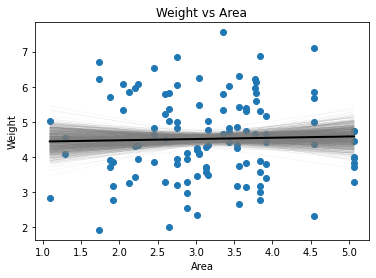

In [19]:
sampling_from_posterior(
    centered_data, mean_area, 
    "weight", "area", 
    posterior_samples, posterior_means,
    "Weight vs Area", "Area", "Weight"
)

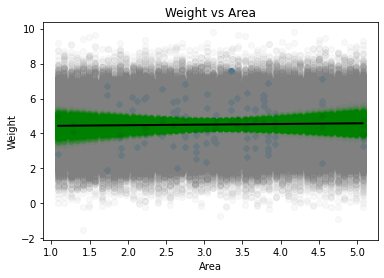

In [20]:
plot_variation(
    centered_data,
    "weight",
    mean_area,
    "area",
    'Weight vs Area',
    "Area",
    "Weight",
    posterior_samples,
    posterior_means,
    higher_order = False,
    max_order = 1
)

<u>Observations:</u>

As suspected, the impact of `area` on an urban fox's `weight` is dubious, as the result of the linear regression yields a near-flat slope $b$. The results are also quite uncertain with regards to the mean prediction as many data points fall beyond the confidence interval, which is why we also estimated the overall posterior uncertainty of the prediction (while accounting for the estimated regression noise). 

As such, we consider `area` to be a (very) weak positive covariate of `weight`.

#### 4. Performing a regression with `weight` as a linear function of `groupsize`

We reproduce with `groupsize` the same workflow as with the variable `area`, but swapping the prior distribution parameters of the slope $b$ such that:

$$p(b)=\mathcal{N}(4., 2.)$$

Though we are not certain with regards to standard deviation, we can estimate by glancing at the distribution plot of `groupsize` that it has its mean close to 4. 

<u>Note 1:</u> It seems that a Poisson distribution with parameter $\lambda=4$ would work as a prior distribution in this case, given the shape of the distribution of the `groupsize` data.

<u>Note 2:</u> Sometimes a domain error is caused when computing plots with the `posterior_samples_2var` argument below when $\sigma$ of the prior distribution of `groupsize` is instead set to 1.

<u>Centering the data:</u>

We center the `groupsize` variable to avoid scale effects.

In [21]:
# Centers the data
mean_groupsize = data["groupsize"].mean()
centered_data["groupsize"] -= mean_groupsize

<u>Performing the Laplace regression:</u>

In [22]:
# Declares the regression expression
expression = "weight ~ groupsize"

# Declares the likelihood
likelihood = "gaussian"

# Defines the prior with hyperparameters 
prior_a_mean = 4.5; prior_a_sigma = 1.2
prior_a = ["gaussian", [prior_a_mean, prior_a_sigma]]

prior_b_mean = 4.; prior_b_sigma = 2.
prior_b = ["gaussian", [prior_b_mean, prior_b_sigma]]

sigma_inf = 0.; sigma_sup = 2.
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ["uniform", prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Performs the optimization
solution = laplace_solution_regression(expression, centered_data, likelihood, priors)

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 187.6959908640995
 hess_inv: array([[ 1.11193029e-02, -2.77459827e-04,  2.32434734e-04],
       [-2.77459827e-04,  4.64912176e-03,  8.19062581e-05],
       [ 2.32434734e-04,  8.19062581e-05,  5.61792984e-03]])
      jac: array([ 3.81469727e-06,  5.72204590e-06, -5.72204590e-06])
  message: 'Optimization terminated successfully.'
     nfev: 89
      nit: 16
     njev: 21
   status: 0
  success: True
        x: array([ 4.52941679, -0.11877779,  1.16355607]) 



<u>Summarizing the computed statistics:</u>

In [23]:
# Computes posterior samples
posterior_means, _, posterior_samples = summarize(solution)

           mean        SD      7.5%     92.5%
a      4.531229  0.103502  4.382120  4.681048
b     -0.118517  0.067719 -0.217180 -0.021945
sigma  1.164851  0.074389  1.056283  1.271064 



<u>Plotting the results with sampling from the posterior:</u>

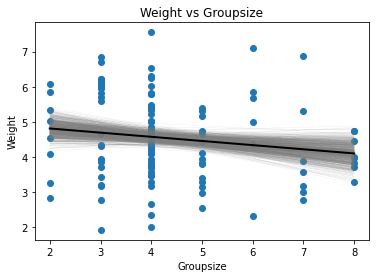

In [24]:
sampling_from_posterior(
    centered_data, mean_groupsize, 
    "weight", "groupsize", 
    posterior_samples, posterior_means,
    "Weight vs Groupsize", "Groupsize", "Weight"
)

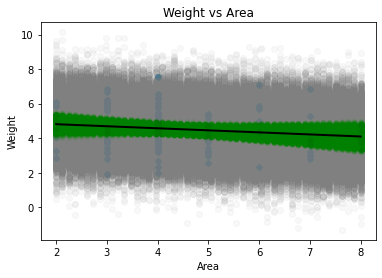

In [25]:
plot_variation(
    centered_data,
    "weight",
    mean_groupsize,
    "groupsize",
    'Weight vs Area',
    "Area",
    "Weight",
    posterior_samples,
    posterior_means,
    higher_order = True,
    max_order = 1
)

<u>Observations:</u>

As with `are`, the impact of `groupsize` on an urban fox's `weight` is weak (albeit in a lesser extent as the slope $b$ is stronger with `groupsize`). The most important difference here is the negative slope $b$, indicating that we can consider `groupsize` as a weakly negative covariate of `weight`.

#### 5. Overall comment on the two regressions

The relationship between the dependent variable `weight` and the covariates `groupsize` and `area` are weakly linear with respective negative and positive relationships. Comparatively, `groupsize` seems to have a relative stronger influence than `area` which is nearly flat.

#### 6. Performing a multivariate model

<u>Running the model:</u>

In [26]:
expr = 'weight ~ area + groupsize'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 4.5
prior_a_sigma = 0.11
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 1.
prior_b_sigma = 1.
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

prior_b2_mean = 4.
prior_b2_sigma = 2.
prior_b2 = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0.
sigma_sup = 2.
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_b2, prior_sigma]

solution_regression_2var = laplace_solution_regression(expr, data, likelihood, priors)

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 179.93185240796305
 hess_inv: array([[ 1.11315765e-02, -3.38598500e-03,  8.72397924e-05,
         4.00290286e-05],
       [-3.38598500e-03,  2.66731641e-02, -1.80129845e-02,
        -1.83218072e-04],
       [ 8.72397924e-05, -1.80129845e-02,  1.31250420e-02,
         1.40173886e-04],
       [ 4.00290286e-05, -1.83218072e-04,  1.40173886e-04,
         5.30322716e-03]])
      jac: array([1.90734863e-06, 0.00000000e+00, 3.81469727e-06, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 147
      nit: 23
     njev: 28
   status: 0
  success: True
        x: array([ 4.49464332,  0.58850079, -0.42009798,  1.1185717 ]) 



In [27]:
posterior_means, _, posterior_samples_2var = summarize(
    solution_regression_2var, names={0:'a',1:'b1', 2:'b2', 3:'sigma'}
)

           mean        SD      7.5%     92.5%
a      4.494120  0.105385  4.343101  4.644405
b1     0.588349  0.163991  0.352639  0.822141
b2    -0.419640  0.114915 -0.584688 -0.253527
sigma  1.118977  0.073000  1.012876  1.223360 



<u>Plotting counterfactual plots:</u>

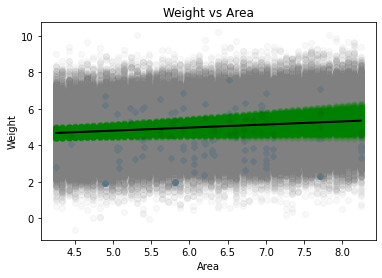

In [28]:
# sometimes causes a domain error

plot_variation(
    data,
    "weight",
    mean_area,
    "area",
    'Weight vs Area',
    "Area",
    "Weight",
    posterior_samples_2var,
    posterior_means,
    higher_order = False,
    max_order = 2
)

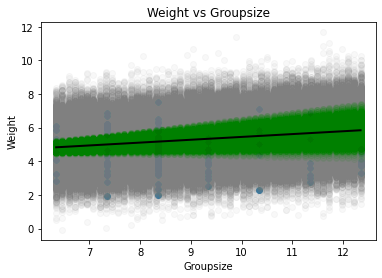

In [29]:
plot_variation(
    data,
    "weight",
    mean_groupsize,
    "groupsize",
    'Weight vs Groupsize',
    "Groupsize",
    "Weight",
    posterior_samples_2var,
    posterior_means,
    higher_order = False,
    max_order = 2
)

<u>Observations:</u>

the larger the `area`, and the larger the `groupsize`, the more uncertain predictions are. This seems tied to the lower number of datapoints as these values increases. This seems logical at first glance as it is doubtful that the distribution of group sizes and area would be uniform (We could come back here to our observations that the distribution of `groupsize` looks similar to a Poisson distribution with parameter $\lambda=4$).

#### 6. Conclusion

Via the application of the multivariate Laplace approximation method, we see that using both variables `area` and `groupsize` leads to slopes `b1` and `b2` increasing in value (i.e. effect) compared to the models where both variables are used by themselves, separately. 

This indicates that there is a feedback loop between the two variables, affecting the resulting `weight` of urban foxes.

Beyond this, Looking at the plots, we find that many data points fall beyond the confidence interval displayed in our plots when the values of `area` and `groupsize` increases. As previously stated, it seems related to the thinning of the available datapoints as their value increases, which makes our analysis and prediction less robust when trying to predict `weight` of foxes owning a larger area, or being part of a larger group.

<hr>
<hr>
<hr>

## Exercise 5

Consider the diabetes dataset:

In [95]:
dataset = datasets.load_diabetes(return_X_y=False)
print(dataset.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [96]:
# Define the feature matrix
raw_data = dataset.data

# Define the target
target = dataset.target

### Instructions

Investigate the relationship between age (data[:,0]) and Average blood pressure (data[:,3]). 
By using the WAIC score seen during lesson, can you verify which hypothesis is better supported by the data?

- there is no relationship (constant)
- the relationship is linear
- the relationship is quadratic
- the relationship is cubic
- the relationship is polynomial of order 4

#### 1. Is there a  relationship between the `age` and `bp` variables?

We want to check whether or not there is a relationship between the two variables. If there is none, we might hypothesize we can eliminate searching for the other four options.

In [97]:
# Retrieves the age and bp variables as a Pandas DataFrame

data = pd.DataFrame(data = raw_data, columns = dataset.feature_names)
data = data[["age", "bp"]]
data.describe()

,age,bp
count,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.281655e-16
std,4.761905e-02,4.761905e-02
min,-1.072256e-01,-1.123996e-01
25%,-3.729927e-02,-3.665645e-02
50%,5.383060e-03,-5.670611e-03
75%,3.807591e-02,3.564384e-02
max,1.107267e-01,1.320442e-01


[Text(0.5, 1.0, 'Distribution of Ages (Diabetes dataset)')]

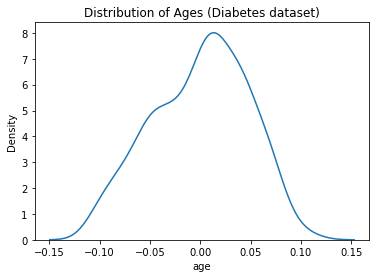

In [98]:
sns.kdeplot(data["age"]).set(title="Distribution of Ages (Diabetes dataset)")

[Text(0.5, 1.0, 'Distribution of Avg. Blood Pressures (Diabetes dataset)')]

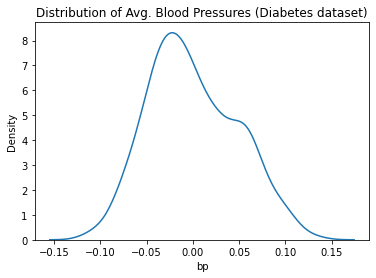

In [99]:
sns.kdeplot(data["bp"]).set(title="Distribution of Avg. Blood Pressures (Diabetes dataset)")

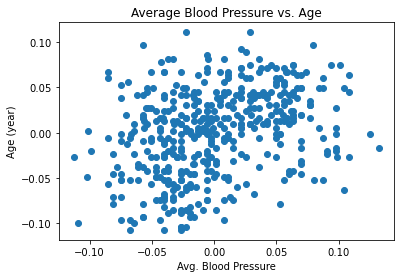

In [100]:
# Plots the relationship between the two variables

plot_relationship(
    data["bp"], data["age"], 
    xlabel="Avg. Blood Pressure", ylabel="Age (year)", 
    title="Average Blood Pressure vs. Age")

<u>Observations:</u>

- We verified the note statement that is part of the dataset's description:

> Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

- At first glance, there seems to be a somewhat positive relationship between the variables `bp` (average blood pressure) and `age`. This is also informed by general knowledge that blood pressure is usually correlated to age, but this phenomenon will have to be assessed statistically.

<u>Studying the simple linear relationship of `age` with `bp`:</u>

Now done with a preliminary exploration of the variables `bp` and `age`, we can further study the relationship between the two variables with statistical methods. As such, we are interested in the relationship: 

\begin{align}
\text{age} &= a + b * \text{bp}\\
age &\sim \mathcal{N}(a+c*\text{bp}, \sigma)
\end{align}

The intercept $a$ expresses the `age` of a patient within the Diabetes dataset when the average blood pressure `bp` is null (here in relative terms as the dataset is centered) while the slope $b$ indicates how much the age of a patient changes with their average blood pressure.

To define our Bayesian model, we specify priors for all the parameters we want to analyze. We resort to a standard normal prior for $a$ and $b$ given the centered-ness of the dataset, the support of each variable and our lack of prior belief. Our lack of prior belief also inform setting the prior distribution of the parameter $\sigma$ as a unfirm distribution.

\begin{align}
p(a) &= \mathcal{N}(0, 1)\\
p(b) &= \mathcal{N}(0, 1)\\
p(\sigma) &= \mathcal{U}(0, 2)
\end{align}

In [124]:
# Declares the regression expression
expression = "age ~ bp"

# Declares the likelihood
likelihood = "gaussian"

# Defines the prior with hyperparameters 
prior_a_mean = 0.; prior_a_sigma = 0.1
prior_a = ["gaussian", [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0.; prior_b_sigma = 0.1
prior_b = ["gaussian", [prior_b_mean, prior_b_sigma]]

sigma_inf = 0.; sigma_sup = 1.
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ["uniform", prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

# Performs the optimization
solution = laplace_solution_regression(expression, data, likelihood, priors)

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -743.4708508960097
 hess_inv: array([[ 4.55010824e-06,  1.18612824e-07, -5.88223788e-08],
       [ 1.18612824e-07,  1.66960805e-03, -5.08681112e-06],
       [-5.88223788e-08, -5.08681112e-06,  2.25546330e-06]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 93
      nit: 12
     njev: 21
   status: 0
  success: True
        x: array([-7.47139197e-09,  2.79172063e-01,  4.48893363e-02]) 



In [125]:
# Computes posterior samples
posterior_means, _, posterior_samples = summarize(solution)

           mean        SD      7.5%     92.5%
a      0.000006  0.002165 -0.003112  0.003156
b      0.278350  0.040537  0.219501  0.336971
sigma  0.044889  0.001507  0.042729  0.047132 



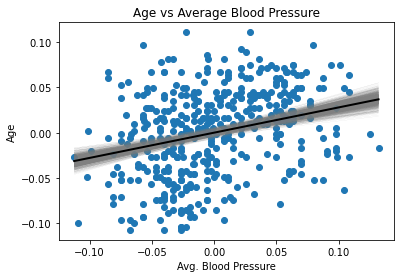

In [126]:
sampling_from_posterior(
    data, 0, 
    "age", "bp", 
    posterior_samples, posterior_means,
    "Age vs Average Blood Pressure", "Avg. Blood Pressure", "Age"
)

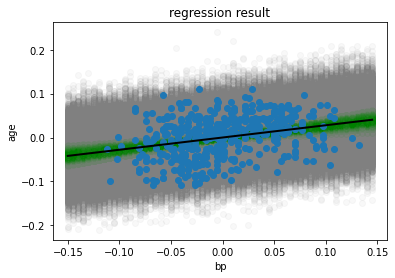

In [127]:
plot_posterior_univariate_regression(
    solution, 
    np.arange(-0.15,0.15,0.005), 
    data, 
    names = ['bp','age']
)

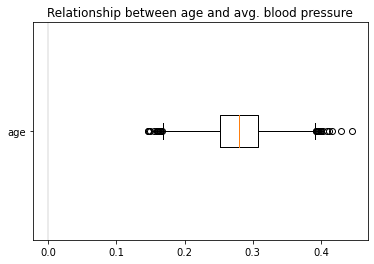

In [128]:
plot_boxplot_regression(
    solution, 
    "age", 
    "Relationship between age and avg. blood pressure"
)

<u>Observations:</u>
    
The posterior mean of the slope $b$ for `bp` is 0.33. Moreover the 85% posterior interval for $b$ is [0.32, 0.34], which lies well away from zero. As such, there is a strong relationship between `age` and its covariate `bp`. We might conclude that `bp` is a reliable predictor of `age` among the patient listed in the Diabetes dataset. 

Now that we have confirmed that there is a relationship, we are interested whether or not it is linear, quadratic, cubic, or of order 4.

#### 2. Application of the WAIC for hypothesis verification

Now that we have settled the observation that there is a positive feedback between the variables `age` and `bp`, we are questioning the kind of relationship it is. We want to test whether the relationship is:

- linear (we already did check above but we will reproduce the process below in order to compute the WAIC)
- quadratic
- cubic
- of order 4

<u>Creating the dataset<u>

In [129]:
data_copy = data.copy()
data_copy['bp2'] = data_copy["bp"] ** 2
data_copy['bp3'] = data_copy["bp"] ** 3
data_copy['bp4'] = data_copy["bp"] ** 4
data_copy.rename(columns={"bp": "bp1"}, inplace=True)

data_copy.describe()

,age,bp1,bp2,bp3,bp4
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.281655e-16,2.262443e-03,3.117309e-05,1.259026e-05
std,4.761905e-02,4.761905e-02,2.736522e-03,3.198483e-04,3.004499e-05
min,-1.072256e-01,-1.123996e-01,4.557233e-09,-1.420020e-03,2.076837e-17
25%,-3.729927e-02,-3.665645e-02,3.076689e-04,-4.925509e-05,9.490351e-08
50%,5.383060e-03,-5.670611e-03,1.270483e-03,-1.823432e-07,1.614127e-06
75%,3.807591e-02,3.564384e-02,3.284857e-03,4.528490e-05,1.079028e-05
max,1.107267e-01,1.320442e-01,1.743568e-02,2.302280e-03,3.040028e-04


<u>Creating the different regression expressions:</u>

In [130]:
linear = "age ~ bp1"
quadratic = "age ~ bp1 + bp2"
cubic = "age ~ bp1 + bp2 + bp3"
order4 = "age ~ bp1 + bp2 + bp3 + bp4"

expressions = [linear, quadratic, cubic, order4]

<u>Running the regression processes:</u>

W e are interested in the relationship:

\begin{align}
age &= a + b*bp &\text{linear}\\
&= a + b*bp + c*bp^2 &\text{quadratic}\\
&= a + b*bp + c*bp^2 + d*bp^3 &\text{cubic}\\
&= a + b*bp + c*bp^2 + d*bp^3 + e*bp^4 &\text{fourth-order}\\
\end{align}

To define our Bayesian model, we specify priors for all the parameters $a$, $b$, $c$, $d$, and $e$ that we want to analyze. We resort to a standard normal prior for all of them given the centered-ness of the dataset, the support of each variable and our lack of prior belief. Our lack of prior belief also inform setting the prior distribution of the parameter $\sigma$ as a unfirm distribution.

\begin{align}
p(a) &= \mathcal{N}(0, 1)\\
p(b) &= \mathcal{N}(0, 1)\\
p(c) &= \mathcal{N}(0, 1)\\
p(d) &= \mathcal{N}(0, 1)\\
p(e) &= \mathcal{N}(0, 1)\\
p(\sigma) &= \mathcal{U}(0, 2)
\end{align}

In [131]:
sampling_size = 5000 # sampling size to compute PDF

lppd = []
p_waic = []

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 1
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

# To avoid memory copies and overwrite, better declare
# separate object
prior_b1_mean = 0; prior_b2_mean = 0
prior_b3_mean = 0; prior_b4_mean = 0
prior_b1_sigma = 1; prior_b2_sigma = 1
prior_b3_sigma = 1; prior_b4_sigma = 1
prior_b1 = ['gaussian', [prior_b1_mean, prior_b1_sigma]]
prior_b2 = ['gaussian', [prior_b2_mean, prior_b2_sigma]]
prior_b3 = ['gaussian', [prior_b3_mean, prior_b3_sigma]]
prior_b4 = ['gaussian', [prior_b4_mean, prior_b4_sigma]]

sigma_inf = 0
sigma_sup = 2
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b1, prior_b2, prior_b3, prior_b4]

solutions = [laplace_solution_regression(
                expressions[i], data_copy, likelihood, 
                priors[:i+2] + [prior_sigma]) 
             for i in range(len(expressions))]

posterior_samples = [posterior_sampling_laplace(solutions[i], sampling_size)
                     for i in range(len(expressions))]

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -742.7998772739714
 hess_inv: array([[ 4.38173366e-06, -3.45475418e-06, -3.91834619e-06],
       [-3.45475418e-06,  2.50639950e-04,  1.27037919e-04],
       [-3.91834619e-06,  1.27037919e-04,  6.54828941e-05]])
      jac: array([-7.62939453e-06,  7.62939453e-06,  1.52587891e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 155
      nit: 25
     njev: 38
   status: 2
  success: False
        x: array([-7.47004593e-09,  3.34754563e-01,  4.48095285e-02]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -742.6203179456522
 hess_inv: array([[ 7.47176427e-06,  6.28094485e-05, -1.42540769e-04,
         1.22325429e-06],
       [ 6.28094485e-05,  2.57103159e-03, -5.30205446e-03,
         2.00644711e-05],
       [-1.42540769e-04, -5.30205446e-03,  1.27168844e-02,
        -4.70664420e-05],
       [ 1.22325429e-06,  2.00644711e-05, -4.70664420e-05,
         2.37459582e-06]])
      jac: array([9.00268555e-04, 4.57763672e-05, 7.62939453e-06, 3.50952148e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 215
      nit: 26
     njev: 43
   status: 2
  success: False
        x: array([ 0.00172311,  0.34523078, -0.76161794,  0.04470493]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -741.7374939720087
 hess_inv: array([[ 4.02015071e-06,  7.30967529e-06, -1.13039126e-05,
         9.52127266e-12, -1.39371055e-07],
       [ 7.30967529e-06,  2.00837013e-03,  2.32458587e-05,
        -1.01863407e-10,  6.01281559e-06],
       [-1.13039126e-05,  2.32458587e-05,  4.49094439e-03,
        -6.38829079e-09, -3.16974035e-07],
       [ 9.52127266e-12, -1.01863407e-10, -6.38829079e-09,
         6.38101483e-09, -2.72848411e-12],
       [-1.39371055e-07,  6.01281559e-06, -3.16974035e-07,
        -2.72848411e-12,  2.13177019e-06]])
      jac: array([2.82287598e-04, 3.05175781e-05, 7.62939453e-06, 7.62939453e-06,
       2.13623047e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 304
      nit: 19
     njev: 49
   status: 2
  success: False
        x: array([ 0.0017246 ,  0.34667711, -0.75858665, -0.26789081,  0.04469783]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: -740.8187496220264
 hess_inv: array([[ 1.23822801e-03,  3.41119207e-03, -1.69636640e-01,
         1.41763123e-03,  4.36186351e-03,  1.89830440e-04],
       [ 3.41119207e-03,  9.42096133e-03, -4.67361507e-01,
         3.85631441e-03,  1.20427643e-02,  5.24541796e-04],
       [-1.69636640e-01, -4.67361507e-01,  2.35007648e+01,
        -2.12417503e-01, -5.97599043e-01, -2.59962914e-02],
       [ 1.41763123e-03,  3.85631441e-03, -2.12417503e-01,
         9.92622114e-01,  4.94522870e-03,  2.24067652e-04],
       [ 4.36186351e-03,  1.20427643e-02, -5.97599043e-01,
         4.94522870e-03,  1.54077523e-02,  6.71890064e-04],
       [ 1.89830440e-04,  5.24541796e-04, -2.59962914e-02,
         2.24067652e-04,  6.71890064e-04,  3.15097115e-05]])
      jac: array([ 1.52587891e-05, -7.62939453e-06,  0.00000000e+00,  0.00000000e+00,
       -7.62939453e-06,  0.00000000e+00])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 597
      nit: 19
     njev: 8

In [132]:
models = ["linear", "quadratic", "cubic", "fourth-order"]
col_names = ["a", "b1", "b2", "b3", "b4", "sigma"]

for i, solution in enumerate(solutions):
    print(f"Regression results for a {models[i]} model:")
    names = dict(zip(range(i + 3), col_names[:i+2]+col_names[-1:]))
    _, _, _ = summarize(solution, names=names); print("\n")

Regression results for a linear model:
           mean        SD      7.5%     92.5%
a     -0.000010  0.002092 -0.003088  0.003006
b1     0.335068  0.016083  0.312098  0.358642
sigma  0.044973  0.008202  0.033232  0.056900 



Regression results for a quadratic model:
           mean        SD      7.5%     92.5%
a      0.001718  0.002686 -0.002119  0.005515
b1     0.343859  0.050178  0.269608  0.417365
b2    -0.759914  0.111677 -0.921635 -0.596989
sigma  0.044685  0.001533  0.042426  0.046877 



Regression results for a cubic model:
           mean        SD      7.5%     92.5%
a      0.001755  0.001970 -0.001119  0.004590
b1     0.345829  0.044935  0.281838  0.410547
b2    -0.758468  0.067431 -0.854730 -0.658497
b3    -0.267891  0.000081 -0.268008 -0.267775
sigma  0.044689  0.001463  0.042610  0.046806 



Regression results for a fourth-order model:
           mean        SD      7.5%     92.5%
a      0.001947  0.035287 -0.047702  0.053236
b1     0.347353  0.097281  0.209928  0.488

<u>Observations:</u>

It appears that the linear, quadratic, and cubic variant of the variable `bp` have an either positive or negative effect on `age`. Only the fourth-order variant `b4` shows a mean near zero, implying that its influence on a regression is near flat. As such, we would tend to hypothesize that either the linear, quadratic, or cubic models are worth keeping. 

The question is which one. To find the proper model, we use the WAIC measure.

<u>Applying the WAIC:</u>

In [133]:
# with n_sampling >> 100, this can take a while

summarize_WAIC_statistics(    
    depvar_name = "age",
    covar_name = "bp",
    max_order = 4, 
    n_sampling = sampling_size,
    posterior_samples = posterior_samples, 
    data = data_copy
)

               WAIC       pWAIC       dWAIC         weight         SE  \
model1 -1383.860304   49.595219  103.650838   2.234228e-23  35.391168   
model2 -1485.633895    3.290999    1.877247   2.811785e-01  25.743036   
model3 -1487.511142    2.578551    0.000000   7.188215e-01  25.724336   
model4  -821.248787  320.599996  666.262355  1.512130e-145  62.009650   

             d_SE  
model1  10.512782  
model2   0.214961  
model3        NaN  
model4  46.342973  


> The WAIC should be interpreted as measure of performance when the model is applied on unseen data. And the SE will help evaluating the uncertainty associated with the WAIC. [...] The Akaike weight helps also to intepret how these different models perform with repsect to each other by giving a relative measure of reliability. The weight should be interpreted as *the probability that the model will make the best predictions on new data, conditional on the set of models considered*.
>
> *From class 8*

<u>Interpretation:</u>

In this context, it seems that, in general, **the third model is the one performing best for this particular dataset**. We also see that following the third model seems to be the best choice when looking at the WAIC. 

**NOTE**: Sometimes, seemingly depending on the value of `n_sampling`, **the linear or the fourth model might show up on top**.

In [134]:
posterior_samples = [posterior_sampling_laplace(solutions[i], sampling_size) for i in range(4)]
boxes = {}

boxes["b1"] = [posterior_samples[i][:,1] for i in range(4)]
boxes["b2"] = [posterior_samples[i][:,2] for i in range(1, 4)]
boxes["b3"] = [posterior_samples[i][:,3] for i in range(2, 4)]
boxes["b4"] = [posterior_samples[i][:,4] for i in range(3, 4)]

model1_boxes = [boxes["b1"][0]]
model2_boxes = [boxes["b1"][1], boxes["b2"][0]]
model3_boxes = [boxes["b1"][2], boxes["b2"][1], boxes["b3"][0]]
model4_boxes = [boxes["b1"][3], boxes["b2"][2], boxes["b3"][1], boxes["b4"][0]]

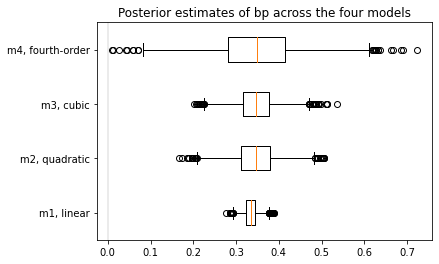

In [135]:
plt.figure()
plt.boxplot([boxes["b1"][i] for i in range(4)],vert=0)
plt.yticks([1,2,3,4], ["m1, linear", "m2, quadratic", "m3, cubic", "m4, fourth-order"])
plt.axvline(x=0, color = 'black', alpha = 0.1)
plt.title('Posterior estimates of bp across the four models')
plt.show()

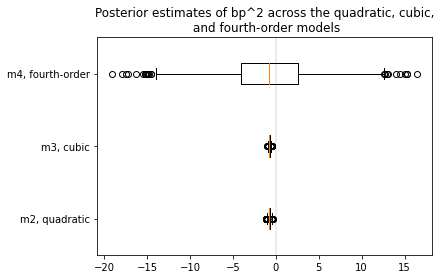

In [136]:
plt.figure()
plt.boxplot([boxes["b2"][i] for i in range(3)],vert=0)
plt.yticks([1,2,3], ["m2, quadratic", "m3, cubic", "m4, fourth-order"])
plt.axvline(x=0, color = 'black', alpha = 0.1)
plt.title('Posterior estimates of bp^2 across the quadratic, cubic,\n and fourth-order models')
plt.show()

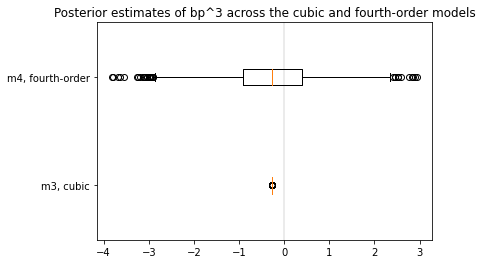

In [137]:
plt.figure()
plt.boxplot([boxes["b3"][i] for i in range(2)],vert=0)
plt.yticks([1,2], ["m3, cubic", "m4, fourth-order"])
plt.axvline(x=0, color = 'black', alpha = 0.1)
plt.title('Posterior estimates of bp^3 across the cubic and fourth-order models')
plt.show()

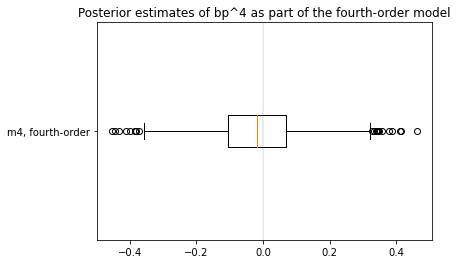

In [138]:
plt.figure()
plt.boxplot(boxes["b4"], vert=0)
plt.yticks([1], ["m4, fourth-order"])
plt.axvline(x=0, color = 'black', alpha = 0.1)
plt.title('Posterior estimates of bp^4 as part of the fourth-order model')
plt.show()

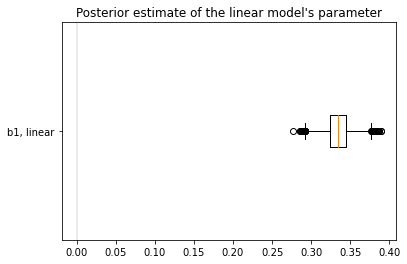

In [139]:
plt.figure()
plt.boxplot(model1_boxes, vert=0)
plt.yticks([1], ["b1, linear"])
plt.axvline(x=0, color = "black", alpha = 0.1)
plt.title("Posterior estimate of the linear model's parameter")
plt.show()

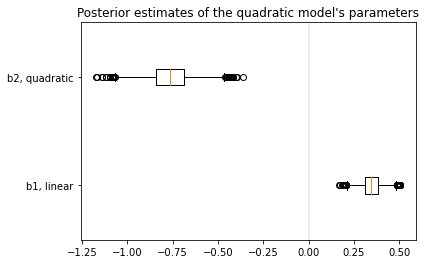

In [140]:
plt.figure()
plt.boxplot(model2_boxes, vert=0)
plt.yticks([1,2], ["b1, linear", "b2, quadratic"])
plt.axvline(x=0, color = "black", alpha = 0.1)
plt.title("Posterior estimates of the quadratic model's parameters")
plt.show()

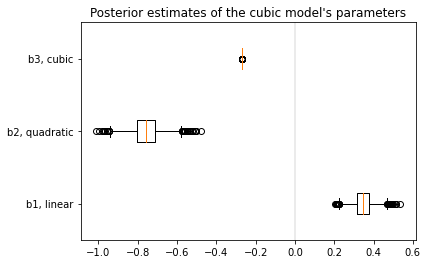

In [141]:
plt.figure()
plt.boxplot(model3_boxes, vert=0)
plt.yticks([1,2,3], ["b1, linear", "b2, quadratic", "b3, cubic"])
plt.axvline(x=0, color = "black", alpha = 0.1)
plt.title("Posterior estimates of the cubic model's parameters")
plt.show()

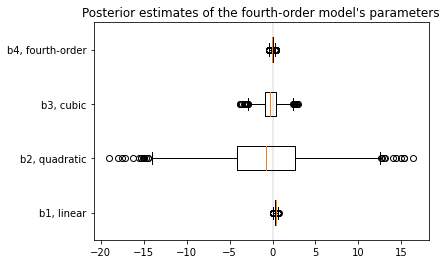

In [142]:
plt.figure()
plt.boxplot(model4_boxes, vert=0)
plt.yticks([1,2,3,4], ["b1, linear", "b2, quadratic", "b3, cubic", "b4, fourth-order"])
plt.axvline(x=0, color = "black", alpha = 0.1)
plt.title("Posterior estimates of the fourth-order model's parameters")
plt.show()

<u>Conclusion:</u>
    
These boxplots show us how the impact of the posterior estimates for the different orders of the variable `bp` when they are added to the regression modeling. By looking at the posterior estimates we see that each parameter besides the fourth one are relatively important to the end value of the regression.

This importance in terms of magnitude is also coupled with the generally lowest WAIC value for the cubic model (most of the time -- otherwise the fourth model comes on top). This the fact that this is the best suited model (among the ones we tested) to describe this dataset.

<hr>
<hr>
<hr>

## Exercise 6

### Instructions

Which model would you support between the following:

- target depends on _Age_
- target depends on _Age_ and _Sex_
- target depends on _Age_ and _Body mass index_ 
- target depends on _Age_ and _Body mass index_ and _Average blood pressure_
- target depends on _Age_ and _Sex_ and _Body mass index_ 
- target depends on _Age_ and _Sex_ and _Body mass index_ and _Average blood pressure_
- target depends on  _Body mass index_ and _Average blood pressure_

<hr>

#### 1. Data import and exploration

In [55]:
data = pd.DataFrame(data = raw_data, columns = dataset.feature_names)
data = data[["age", "sex", "bmi", "bp"]]
data["target"] = pd.Series(target)

data

,age,sex,bmi,bp,target
0,0.038076,0.050680,0.061696,0.021872,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,75.0
2,0.085299,0.050680,0.044451,-0.005671,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,206.0
4,0.005383,-0.044642,-0.036385,0.021872,135.0
...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,104.0
439,0.041708,0.050680,-0.015906,0.017282,132.0
440,-0.045472,-0.044642,0.039062,0.001215,220.0


[Text(0.5, 1.0, 'Distribution of Ages (Diabetes dataset)')]

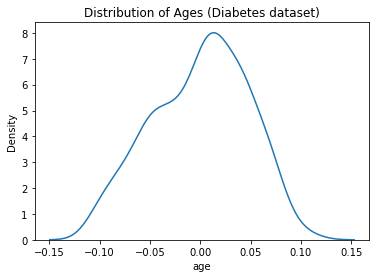

In [56]:
sns.kdeplot(data["age"]).set(title="Distribution of Ages (Diabetes dataset)")

[Text(0.5, 1.0, 'Distribution of BMI (Diabetes dataset)')]

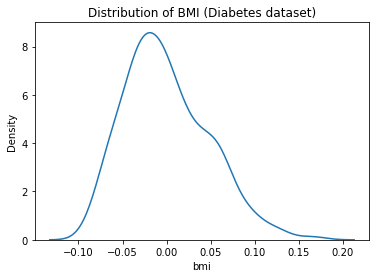

In [57]:
sns.kdeplot(data["bmi"]).set(title="Distribution of BMI (Diabetes dataset)")

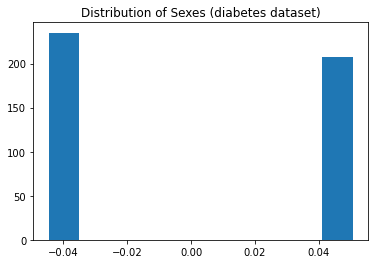

In [58]:
plt.hist(data["sex"])
plt.title("Distribution of Sexes (diabetes dataset)")
plt.show()

[Text(0.5, 1.0, 'Distribution of Target (Diabetes dataset)')]

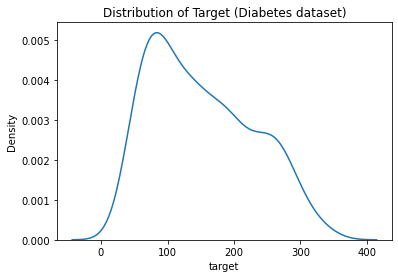

In [59]:
sns.kdeplot(data["target"]).set(title="Distribution of Target (Diabetes dataset)")

<u>Declaring the regression expression:</u>

In [60]:
expressions = {
    "model_1_a" : ["target ~ age", {0:"a", 1:"age", 2:"sigma"}],
    "model_2_as" : ["target ~ age + sex", {0:"a", 1:"age", 2: "sex", 3: "sigma"}],
    "model_3_abm" : ["target ~ age + bp", {0:"a", 1:"age", 2: "bp", 3: "sigma"}],
    "model_4_abmbp" : ["target ~ age + bmi + bp", {0:"a", 1:"age", 2: "bmi", 3: "bp", 4: "sigma"}],
    "model_5_asbp" : ["target ~ age + sex + bp", {0:"a", 1:"age", 2: "sex", 3: "bp", 4: "sigma"}],
    "model_6_asbmbp" : ["target ~ age + sex + bmi + bp", {0:"a", 1:"age", 2: "sex", 3: "bmi", 4: "bp", 5: "sigma"}],
    "model_7_bmbp" : ["target ~ bmi + bp", {0:"a", 1: "bmi", 2: "bp", 3: "sigma"}]
}

<u>Defining the prior parameters and preparing for the regression analysis:</u>

In [61]:
# Initializing the likelihood
likelihood = 'gaussian'

# Defining the priors with hyperparameters 

prior_a_mean = 0
prior_a_sigma = 1
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_age_mean = 0; prior_age_sigma = 1
prior_bp_mean = 0; prior_bp_sigma = 1
prior_bmi_mean = 0; prior_bmi_sigma = 1
prior_sex = ['gaussian', [0, 1]]
prior_age = ["gaussian", [prior_age_mean, prior_age_sigma]]
prior_bmi = ['gaussian', [prior_bmi_mean, prior_bmi_sigma]]
prior_bp = ['gaussian', [prior_bp_mean, prior_bp_sigma]]

sigma_inf = 0
sigma_sup = 2
prior_sigma = ['uniform', [sigma_inf, sigma_sup]]

In [62]:
priors = {
    "model_1_a" : [prior_a, prior_age, prior_sigma], 
    "model_2_as" : [prior_a, prior_age, prior_sex, prior_sigma], 
    "model_3_abm" : [prior_a, prior_age, prior_bmi, prior_sigma],
    "model_4_abmbp" : [prior_a, prior_age, prior_bmi, prior_bp, prior_sigma], 
    "model_5_asbp" : [prior_a, prior_age, prior_sex, prior_bp, prior_sigma], 
    "model_6_asbmbp" : [prior_a, prior_age, prior_sex, prior_bmi, prior_bp, prior_sigma], 
    "model_7_bmbp" : [prior_a, prior_bmi, prior_bp, prior_sigma]
}

<u>Running the regressions:</u>

In [63]:
solutions = [laplace_solution_regression(expressions[model][0], data, likelihood, priors[model]) 
             for model in priors.keys()]

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 372937.5181415787
 hess_inv: array([[ 2.40714172e-03, -3.54256104e-03, -6.03524517e-07],
       [-3.54256104e-03,  7.22143319e-01, -6.19163705e-05],
       [-6.03524517e-07, -6.19163705e-05,  1.63702258e-06]])
      jac: array([-2.77023438e+03, -5.04687500e+01, -3.63868984e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 116
      nit: 10
     njev: 23
   status: 2
  success: False
        x: array([125.92464362,  20.46563073,   1.99996994]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 341797.92980157724
 hess_inv: array([[ 3.45254531e-03,  6.99454983e-03, -3.92883068e-04,
         2.15011338e-06],
       [ 6.99454983e-03,  7.14830335e-01, -1.23608635e-01,
        -1.22759948e-04],
       [-3.92883068e-04, -1.23608635e-01,  8.98513409e-01,
        -7.40573210e-06],
       [ 2.15011338e-06, -1.22759948e-04, -7.40573210e-06,
         1.83526443e-06]])
      jac: array([-6.32878906e+02, -6.12890625e+00,  2.04218750e+01, -3.29622914e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 145
      nit: 8
     njev: 26
   status: 2
  success: False
        x: array([145.14489629,  55.3120066 ,  28.40796181,   1.99255472]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 345444.5273453999
 hess_inv: array([[ 4.39938247e-03, -4.52244807e-04,  6.73517428e-03,
        -2.86471223e-06],
       [-4.52244807e-04,  8.33055138e-01, -1.19151123e-01,
        -9.96331047e-05],
       [ 6.73517428e-03, -1.19151123e-01,  6.37302698e-01,
        -2.78548663e-04],
       [-2.86471223e-06, -9.96331047e-05, -2.78548663e-04,
         1.29898525e-06]])
      jac: array([-1.32391797e+03,  3.05390625e+01, -5.21914062e+01, -3.32459633e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 110
      nit: 6
     njev: 20
   status: 2
  success: False
        x: array([139.35372991,  79.93344644, 100.08623371,   1.96476395]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 323925.79330911645
 hess_inv: array([[ 4.26549797e-03, -4.15636976e-04,  9.17363446e-03,
         4.25879328e-03,  3.25248540e-07],
       [-4.15636976e-04,  7.69424294e-01, -4.73063859e-02,
        -1.77902184e-01, -7.19021810e-05],
       [ 9.17363446e-03, -4.73063859e-02,  7.47481530e-01,
        -1.75252256e-01, -4.12017494e-04],
       [ 4.25879328e-03, -1.77902184e-01, -1.75252256e-01,
         7.81679330e-01, -2.63136556e-04],
       [ 3.25248540e-07, -7.19021810e-05, -4.12017494e-04,
        -2.63136556e-04,  2.08491979e-06]])
      jac: array([-1.04530469e+03,  9.41406250e-01, -7.91406250e+01, -4.23906250e+01,
       -3.04851832e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 169
      nit: 8
     njev: 26
   status: 2
  success: False
        x: array([141.796252  ,  51.86260513, 122.83426325, 100.14892471,
         1.96186719]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 342377.09737309645
 hess_inv: array([[ 8.05445707e-03,  6.29622739e-04, -1.20537269e-03,
         5.81935274e-03, -3.07426330e-05],
       [ 6.29622739e-04,  8.65282149e-01, -9.07087584e-02,
        -1.53217175e-01, -9.28693701e-05],
       [-1.20537269e-03, -9.07087584e-02,  9.07820975e-01,
        -2.56752239e-02,  1.58270998e-05],
       [ 5.81935274e-03, -1.53217175e-01, -2.56752239e-02,
         6.25750603e-01, -3.05278984e-04],
       [-3.07426330e-05, -9.28693701e-05,  1.58270998e-05,
        -3.05278984e-04,  2.07265855e-06]])
      jac: array([-1.79513281e+03, -3.77343750e+00, -4.64062500e+00,  7.48437500e+00,
       -3.21839578e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 160
      nit: 7
     njev: 24
   status: 2
  success: False
        x: array([134.8191085 ,  48.28936477,   1.52934996, 146.58221361,
         1.99131962]) 



/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 330565.99013277347
 hess_inv: array([[ 4.90296729e-03, -4.14996810e-04, -3.21099493e-03,
         9.08756483e-03,  4.54602065e-03, -3.46163344e-06],
       [-4.14996810e-04,  8.78542957e-01, -9.18314136e-02,
        -1.23366694e-01, -1.51354634e-01, -5.53918898e-05],
       [-3.21099493e-03, -9.18314136e-02,  9.30580114e-01,
        -9.51315089e-02, -1.15262156e-01,  1.63996662e-05],
       [ 9.08756483e-03, -1.23366694e-01, -9.51315089e-02,
         8.88149080e-01, -1.47222962e-01, -3.10999848e-04],
       [ 4.54602065e-03, -1.51354634e-01, -1.15262156e-01,
        -1.47222962e-01,  8.14514274e-01, -2.01140063e-04],
       [-3.46163344e-06, -5.53918898e-05,  1.63996662e-05,
        -3.10999848e-04, -2.01140063e-04,  1.64531674e-06]])
      jac: array([-1.70730469e+02, -5.30976562e+01, -2.60039062e+01, -1.06402344e+02,
       -9.37578125e+01, -3.19594062e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 118
      nit: 8
     njev: 15

/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/quentin/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 322795.1974574542
 hess_inv: array([[ 5.42187896e-03,  7.41681756e-03,  1.03704692e-02,
        -1.04050608e-05],
       [ 7.41681756e-03,  7.92185955e-01, -1.75659744e-01,
        -3.50422158e-04],
       [ 1.03704692e-02, -1.75659744e-01,  8.06789105e-01,
        -2.73396907e-04],
       [-1.04050608e-05, -3.50422158e-04, -2.73396907e-04,
         1.64028786e-06]])
      jac: array([-1.03678125e+03, -2.10234375e+01, -2.33632812e+01, -2.96528156e+05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 101
      nit: 7
     njev: 18
   status: 2
  success: False
        x: array([141.87840632, 169.85961487, 115.10050017,   1.9610411 ]) 



In [64]:
posterior_samples = [posterior_sampling_laplace(solutions[i], sampling_size)
                     for i in range(len(expressions))]

In [65]:
for i, exp in enumerate(expressions):
    print(f"Regression results for {exp}:")
    _, _, _ = summarize(solutions[i], names=expressions[exp][1]); print("\n")

Regression results for model_1_a:
             mean        SD        7.5%       92.5%
a      125.923575  0.048461  125.853991  125.992673
age     20.459431  0.834574   19.260483   21.627754
sigma    1.999975  0.001275    1.998144    2.001821 



Regression results for model_2_as:
             mean        SD        7.5%       92.5%
a      145.145151  0.058861  145.058909  145.229583
age     55.314078  0.840983   54.092749   56.539250
sex     28.402821  0.934669   27.046809   29.755498
sigma    1.992561  0.001343    1.990617    1.994498 



Regression results for model_3_abm:
             mean        SD        7.5%       92.5%
a      139.352393  0.066517  139.255730  139.450131
age     79.928067  0.915291   78.605956   81.227298
bp     100.078337  0.812800   98.919132  101.231506
sigma    1.964784  0.001139    1.963161    1.966408 



Regression results for model_4_abmbp:
             mean        SD        7.5%       92.5%
a      141.797293  0.064295  141.704023  141.889766
age     51.87

In [66]:
summarize_WAIC_statistics_different_models(
    "target",
    5000,
    data,
    expressions,
    solutions
)

                         WAIC        pWAIC          dWAIC  weight  \
model_1_a       719436.843070  1721.033054  138022.580045     0.0   
model_2_as      651656.566979  1878.060030   70242.303954     0.0   
model_3_abm     658227.699103  1845.623634   76813.436077     0.0   
model_4_abmbp   618764.611639  2419.934704   37350.348614     0.0   
model_5_asbp    682123.999323  3049.387897  100709.736298     0.0   
model_6_asbmbp  653252.797921  2921.083406   71838.534896     0.0   
model_7_bmbp    581414.263025  1766.543468       0.000000     1.0   

                          SE          d_SE  
model_1_a       45519.093119  18005.889144  
model_2_as      35409.599593   8982.743017  
model_3_abm     38151.698640   9164.856779  
model_4_abmbp   35166.913979   6145.447863  
model_5_asbp    40679.184646  12471.352305  
model_6_asbmbp  34681.651049   9006.882099  
model_7_bmbp    32570.480791           NaN  
